# Snowball Rolling

Suppose that we had a inclinated plane with a snowball in the higher zone. At the end onf that plane, there is a tree that requires a force of $25000N$ to get broke. The equations for the dynamics moves of the snowball are:

\begin{equation}
\Large\begin{array}{c}
\frac{dm}{dt}=\beta K_0e^{-\beta t} \\
\frac{dr}{dt}=\frac{\beta K_0e^{-\beta t}}{4\pi\rho r^2} \\
\frac{dx}{dt}=v \\
\frac{dv}{dt}=-\frac{15\rho_aC_d}{56\rho}\frac{v^2}{r}-\frac{23v}{7r}\frac{\beta K_0e^{-\beta t}}{4\pi\rho r^2}+\frac{5}{7}gsin(\theta)
\end{array}
\end{equation}

While the impact force is $F=\frac{K_E}{r}$, where $K_E$ is the kinetic energy. That equation is:

\begin{equation}
K_E=\frac{1}{2}mv^2
\end{equation}

If we had the following values

* $K_0=85$ where $k$ is on the growth factor of the snowball
* $\beta=0.07$ where $\beta$ is the second growth factor.
* $C_d=0.3$ where $C_d$ is the drag coefficient.
* $\rho=350$ where is the snow density.
* $\theta=5°$ and is the inclination of the plane.
* $\rho_a=0.9$ and is the air density.
* $m_0=10$ and it's the initial mass.

Solve the equation for the first $t=30s$ and check the impact force. The snowball will can broke the tree?

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.optimize import minimize
from numba import njit
from jupyterthemes import jtplot
jtplot.style(theme='monokai')

Create the variables to use.

In [4]:
#---------------#
# Variables     #
#---------------#

K0=85     #Growth factor 1
beta=0.07 #Growth factor 2
Cd=0.3    #Drag coefficient
rho=350   #Snow density
rho_a=0.9 #Air density
g=9.8     #Gravity
theta=np.radians(5)  #Theta of the plane
m0=10     #initial mass of the snowball
r0=(3*m0/(4*np.pi*rho))**(1/3) #initial radius of the snowball
x0=0      #Initial position
v0=0      #initial velocity
tf=30     #Total time of simulation
N=301     #Grid points
dt=(tf)/(N-1) #Timestep
t=np.linspace(0,tf,N) #Time array

The first thing that you need to do is discretize the equations. For this PDE solutions, i'm going to use Runge-Kutta. This method had a error of $O(h^4)$ so it's really approximate to the real solution. This method consist on solve 4 different values of $K_n$ and with that, solve for $x_{i+1}$. That four $K_n$ are:

\begin{equation}
\large\begin{array}{c}
K_1=hf(t_n,x_n) \\
K_2=hf(t_n+\frac{h}{2},x_n+\frac{K_1}{2}) \\
K_3=hf(t_n+\frac{h}{2},x_n+\frac{K_2}{2}) \\
K_4=hf(t_n+h,x_n+K_3 )
\end{array}
\end{equation}

But, what is $f(t_n,x_n)$? Well, suppose that you had a ODE like this $\frac{dx}{dt}=x+t$. In this case, the function is $f(t_n,x_n)=x_n+t_n$. Once the function is $f(t_n+h,x_n+h)$ you will have $(x_n+h)+(t_n+h)$. In this case, $h$ is $\Delta t$.

Once that all that $K$ are evaluated, I can evaluate $x_{n+1}$.

\begin{equation}
x_{n+1}=x_n+\frac{k_1}{6}+\frac{k_2}{3}+\frac{k_3}{3}+\frac{k_4}{6}
\end{equation}

It's easy! You can create four different functions that solve Runge Kutta for every PDE. Let's take a look

In [6]:
#Function of dm/dt
#@njit()
def f1(t,beta,K0,rho):
    #global beta, K0, rho
    return beta*K0*np.exp(-beta*t)

#Function of dr/dt
@njit()
def f2(t,r,beta,K0,rho):
    #global beta, K0, rho
    return beta*K0*np.exp(-beta*t)/(4*np.pi*rho*r**2)

#Function of dx/dt
@njit()
def f3(v):
    return v

#Funciton of dv/dt
@njit()
def f4(t,v,r,beta,K0,rho,rho_a,Cd,g,theta):
    #global beta, K0, rho, rho_a, Cd, g, theta
    T1=-15*rho_a*Cd/(56*rho)*(v**2/r)
    T2=-23*v/(7*r)*(beta*K0*np.exp(-beta*t))/(4*np.pi*rho*r**2)
    T3=5/7*g*np.sin(theta)
    return T1+T2+T3

Now, create the functions to calculate Runge-Kutta to every ODE

In [8]:
#Runge Kutta for dm/dt
#@njit()
def runge_kuta_m(dt,m,t,beta,K0,rho):
    k1=dt*f1(t,beta,K0,rho)
    k2=dt*f1(t+dt/2,beta,K0,rho)
    k3=dt*f1(t+dt/2,beta,K0,rho)
    k4=dt*f1(t+dt,beta,K0,rho)
    sol=m+k1/6+k2/3+k3/3+k4/6
    return sol

#Runge Kutta for dr/dt
#@njit()
def runge_kuta_r(dt,r,t,beta, K0, rho):
    k1=dt*f2(t,r,beta,K0,rho)
    k2=dt*f2(t+dt/2,r+k1/2,beta,K0,rho)
    k3=dt*f2(t+dt/2,r+k2/2,beta,K0,rho)
    k4=dt*f2(t+dt,r+k3,beta,K0,rho)
    sol=r+k1/6+k2/3+k3/3+k4/6
    return sol

#Runge Kutta for dx/dt
#@njit()
def runge_kuta_x(dt,x,v):
    k1=dt*f3(v)
    k2=dt*f3(v)
    k3=dt*f3(v)
    k4=dt*f3(v)
    sol=x+k1/6+k2/3+k3/3+k4/6
    return sol

#Runge Kutta for dv/dt
#@njit()
def runge_kuta_v(dt,v,t,r,beta,K0,rho,rho_a,Cd,g,theta):
    k1=dt*f4(t,v,r,beta, K0, rho, rho_a, Cd, g, theta)
    k2=dt*f4(t+dt/2,v+k1/2,r,beta, K0, rho, rho_a, Cd, g, theta)
    k3=dt*f4(t+dt/2,v+k2/2,r,beta, K0, rho, rho_a, Cd, g, theta)
    k4=dt*f4(t+dt,v+k3,r,beta, K0, rho, rho_a, Cd, g, theta)
    sol=v+k1/6+k2/3+k3/3+k4/6
    return sol

Now, create a function that calculates the solution for all the ODEs. and also put the initial conditions.

In [10]:
#@njit()
def solution(N,m0,r0,x0,v0,t,dt,beta,K0,rho,rho_a,Cd,g,theta):
    m,r,x,v=IC(N,m0,r0,x0,v0) #Call the functions to creathe the matrix solutions
    #Now, performance the solution of the ODEs
    for i in range(N-1):
        m[i+1]=runge_kuta_m(dt,m[i],t[i],beta,K0,rho)
        r[i+1]=runge_kuta_r(dt,r[i],t[i],beta,K0,rho)
        x[i+1]=runge_kuta_x(dt,x[i],v[i])
        v[i+1]=runge_kuta_v(dt,v[i],t[i],r[i],beta,K0,rho,rho_a,Cd,g,theta)
    return m,r,x,v


#@njit()
def IC(N,m0,r0,x0,v0):
    #Create the matrix solution
    m=np.zeros(N)
    r=np.zeros(N)
    x=np.zeros(N)
    v=np.zeros(N)
    #Put the initial values
    m[0]=m0
    r[0]=r0
    x[0]=x0
    v[0]=v0
    return m,r,x,v

In [12]:
%time m,r,x,v=solution(N,m0,r0,x0,v0,t,dt,beta,K0,rho,rho_a,Cd,g,theta) #Solve and save the results

#Kinetic Energy
kE=0.5*m*v**2
#Impact Force per time step
F_i=kE/r

CPU times: user 20.5 ms, sys: 0 ns, total: 20.5 ms
Wall time: 20.3 ms


The final impact force is F=15404.21 N


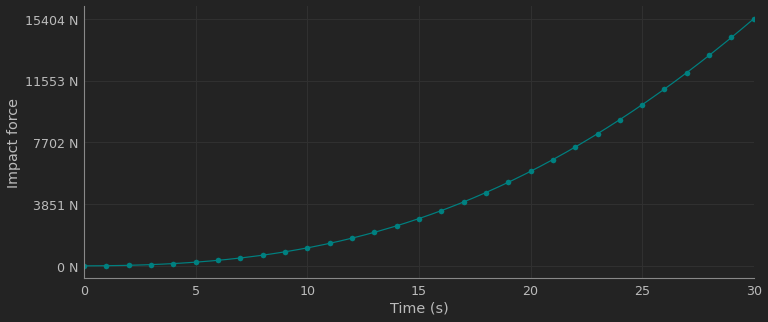

In [14]:
def plot(t,F_i,N):
    fig,axs=plt.subplots(1,figsize=(12,5))
    axs.plot(t,F_i,color='teal',marker='o',markevery=10)
    axs.set_xlim(t[0],t[N-1])
    axs.spines['right'].set_visible(False)
    axs.spines['top'].set_visible(False)
    #X label
    axs.set_xlabel('Time (s)')
    #Y label
    axs.set_ylabel('Impact force')
    yticks=np.linspace(F_i[0],F_i[N-1],5)
    axs.set_yticks(yticks)
    axs.set_yticklabels(['{0:.0f} N'.format(yticks[i]) for i in range(len(yticks))])
    print('The final impact force is F={0:.02f} N'.format(F_i[N-1]))

plot(t,F_i,N)

We have a problem, the snowball can't broke the tree at the end of the road. We can see that the $v_0$ and $x_0$ doesn't affect to much to our system, so what values of $m_0$ and $r_0$ do we need to broke the three? Well, you can know it using SciPy. 

SciPy is great for scientific problems, they have functions to calculate a lot of thing like delta, and also have to many constants that Numpy and others libraries not. It works also for integrate and solve ODE, but in this case I only gonna use the optimization functions. I want to know what are the minimal value for $m_0$ (remembber, $r_0$ depends of $m_0$) to broke the tree in only 30s, keeping all the others variables like at the start. I'm gonna use the function *minimize()* to do the task.

*minimize()* requieres a function that calculate a value with one input. The function must return a value that need to aproach to $0$ to complete the minimization. Let's take a look at what I've done

         Current function value: 0.000002
         Iterations: 2
         Function evaluations: 96
         Gradient evaluations: 42


The optimize initial mass is 46.57 kg
The optimize initial radius is 0.32 m
The final impact force is F=25000.00 N


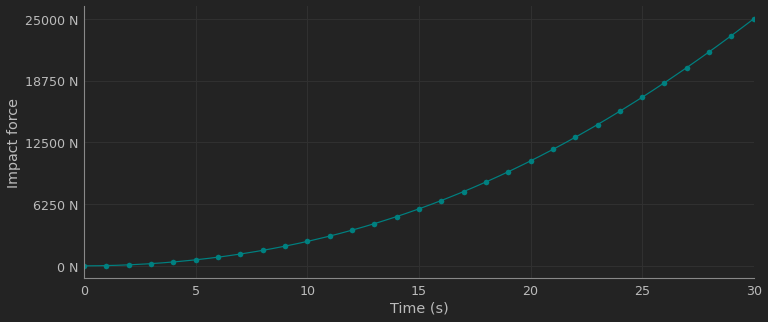

In [16]:
#Function to minimize(). I use m0 as the input value.
def optimization(m0): 
    global K0,beta,Cd,rho,rho_a,g,theta,x0,v0,dt,t,N
    #I calculate r0 using m0
    r0=(3*m0/(4*np.pi*rho))**(1/3)

    #Now, i solve the system of ODE using r0 and m0
    m,r,x,v=solution(N,m0,r0,x0,v0,t,dt,beta,K0,rho,rho_a,Cd,g,theta)

    #Now, i calculate the kinetic energy and the Impact force. Like i'm only interest in the final impact force, i'm gonna use the last values of kE and F_i
    #Kinetic Energy
    kE=0.5*m[N-1]*v[N-1]**2
    #Impact Force per time step
    F_i=kE/r[N-1]

    return abs(F_i-25000) #I create F_i-25000 because the tree needs a final impact force of 25000. When the value are close to 0, then i have the right m0 value

#Now, use the minimize function to solve the problem
res= minimize(optimization,m0,method='BFGS',tol=1e-6,options={'disp':True})
print('\n')

#Now, get the optimize m0 and r0
m0_opt=res.x[0]
r0_opt=(3*m0_opt/(4*np.pi*rho))**(1/3)
#Print the values
print('''The optimize initial mass is {f} kg
The optimize initial radius is {d} m'''.format(f=round(m0_opt,2),d=round(r0_opt,2)))


#Solve the equations
m,r,x,v=solution(N,m0_opt,r0_opt,x0,v0,t,dt,beta,K0,rho,rho_a,Cd,g,theta)

#Kinetic Energy
kE=0.5*m*v**2
#Impact Force per time step
F_i=kE/r

plot(t,F_i,N)

That's good! If the initial mass is $m_0=46.57kg$ then the snowball will broke the tree. And that's all! Now you know how to optimize some systems using SciPy.

In [22]:
fig,axs=plt.subplots(1,figsize=(12,5))
line,=axs.plot([],[],color='teal',marker='o',markevery=10)
axs.set_xlim(t[0],t[N-1])
axs.set_ylim(F_i[0]-100,F_i[N-1]+100)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
#X label
axs.set_xlabel('Time (s)')
#Y label
axs.set_ylabel('Impact force')
yticks=np.linspace(F_i[0],F_i[N-1],5)
axs.set_yticks(yticks)
axs.set_yticklabels(['{0:.0f} N'.format(yticks[i]) for i in range(len(yticks))])

m0_array=np.linspace(m0,m0_opt,N)

def animate(i):
    global K0,beta,Cd,rho,rho_a,g,theta,x0,v0,dt,t,N, m0_array
    #I creathe r0 using m0
    r0=(3*m0_array[i]/(4*np.pi*rho))**(1/3)

    #Now, i solve the system of ODE using r0 and m0
    m,r,x,v=solution(N,m0_array[i],r0,x0,v0,t,dt,beta,K0,rho,rho_a,Cd,g,theta)

    #Now, i calculate the kinetic energy and the Impact force. Like i'm only interest      in the final impact force, i'm gonna use the last values of kE and F_i
    #Kinetic Energy
    kE=0.5*m*v**2
    #Impact Force per time step
    F_i=kE/r

    line.set_data(t,F_i)
    fill=axs.fill_between(t,F_i,0, color='teal',alpha=0.1)
    axs.set_title('Initial mass $m_0$={0:.2f} kg'.format(m0_array[i]))
    return line, fill

anim=FuncAnimation(fig,animate,frames=N,interval=60,blit=True)
plt.close()

%time anim.save('Impact_Force.mp4',fps=60,extra_args=['-vcodec','libx264'])

CPU times: user 2min 29s, sys: 792 ms, total: 2min 30s
Wall time: 2min 31s
